<H3 align = "left"> Detecting Arrhythmia Variant using Electrocardiogram Data </H3>

In [1]:
##############################################
## Packages Needed for this Assignmnent ##
##############################################

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.linear_model import Ridge
from statistics import mean
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import VotingClassifier, BaggingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from tabulate import tabulate


In [2]:
# Import the dataset
dataset = pd.read_csv("MIT-BIH Arrhythmia Database.csv")

TODO:
- take representative sample of dataset (aim for 15,000 rows)
- perform preprocessing 

In [3]:
# Random_state=42 ensures that each time this code runs, we will get the same N rows in the sample 
sampleOfData = dataset.sample(n=15000, random_state=777)

# To get different samples use sampleOfData = dataset.sample(n=NUMBER) 
#sampleOfData = dataset.sample(n=15000)


## Understanding the Data

- "record" is the name of the subject/patient.
- "type" is the target, which contains 5 categories of heartbeats:
    1. N (Normal)
    2. SVEB (Supraventricular ectopic beat)
    3. VEB (Ventricular ectopic beat)
    4. F (Fusion beat)
    5. Q (Unknown beat) <-- Will be removed because not so useful to our goal

## Data Visualization 

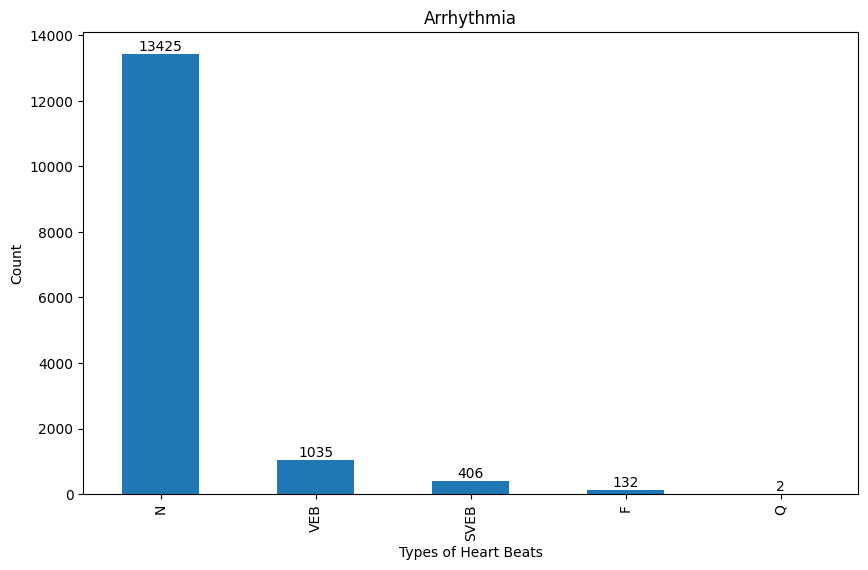

In [4]:
# Entire dataset 
# data = dataset['type'].value_counts()

# Sample dataset 
data = sampleOfData['type'].value_counts()

# Create a bar plot
plt.figure(figsize=(10,6))
bars = data.plot(kind='bar')

# Set the title and labels
plt.title('Arrhythmia')
plt.xlabel('Types of Heart Beats')
plt.ylabel('Count')

for container in bars.containers:
    bars.bar_label(container)

# Show the plot
plt.show()

### Don't remove the comment below until final! It will take a lot of spaces

In [5]:
#data visualization (before data cleaning)
# features = sampleOfData.drop('type', axis=1).columns
# target = sampleOfData['type']

# fig, axs = plt.subplots(len(features), 1, figsize=(5, 5*len(features)))

# for i, feature in enumerate(features):
#     axs[i].scatter(sampleOfData[feature], target)
#     axs[i].set_xlabel(feature)
#     axs[i].set_ylabel('Heartbeat')

# plt.tight_layout()
# plt.show()

## Data cleaning

In [6]:
#we drop "record" column from our dataset because it is not helpful as "record" is the name of the subject/patient.
sampleOfData.drop('record', axis=1, inplace=True)

In [7]:
# Function to replace outliers with the mean of that column (NOTE: I USED SAMPLEDATA NOT DATA)
# def replaceOutliers (sd, column):
#     Q1 = sd[column].quantile(0.25)
#     Q3 = sd[column].quantile(0.75)
#     IQR = Q3 - Q1
#     lowerBound = Q1 - 1.5 * IQR
#     upperBound = Q3 + 1.5 * IQR

#     # Calculating the mean W/O outliers 
#     temp = sd[(sd[column] >= lowerBound) & (sd[column] <= upperBound)]
#     mean = temp[column].mean()
    
#     sd.loc[(sd[column] < lowerBound) | (sd[column] > upperBound), column] = mean
#     return sd

# # Columns we want to check for outliers 
# columnCheck = [
#     '0_pre-RR', '0_post-RR', '0_pPeak', '0_tPeak',
#     '0_rPeak', '0_sPeak', '0_qPeak', '0_qrs_interval',
#     '0_pq_interval', '0_qt_interval', '0_st_interval', '0_qrs_morph0',
#     '0_qrs_morph1', '0_qrs_morph2', '0_qrs_morph3', '1_pre-RR', '1_post-RR',
#     '1_pPeak', '1_tPeak', '1_rPeak', '1_sPeak', '1_qPeak',
#     '1_qrs_interval', '1_pq_interval', '1_qt_interval', '1_st_interval', '1_qrs_morph0', '1_qrs_morph1',
#     '1_qrs_morph2', '1_qrs_morph2', '1_qrs_morph4'
# ]

# for col in columnCheck:
#     sampleOfData = replaceOutliers(sampleOfData, col)


# # Seeing if theres still same amount of rows after replacing outliers 
# print(sampleOfData.shape)


In [8]:
#check for the null or missing value in the dataset
dataset.isnull().sum()
sampleOfData.isnull().sum()

type              0
0_pre-RR          0
0_post-RR         0
0_pPeak           0
0_tPeak           0
0_rPeak           0
0_sPeak           0
0_qPeak           0
0_qrs_interval    0
0_pq_interval     0
0_qt_interval     0
0_st_interval     0
0_qrs_morph0      0
0_qrs_morph1      0
0_qrs_morph2      0
0_qrs_morph3      0
0_qrs_morph4      0
1_pre-RR          0
1_post-RR         0
1_pPeak           0
1_tPeak           0
1_rPeak           0
1_sPeak           0
1_qPeak           0
1_qrs_interval    0
1_pq_interval     0
1_qt_interval     0
1_st_interval     0
1_qrs_morph0      0
1_qrs_morph1      0
1_qrs_morph2      0
1_qrs_morph3      0
1_qrs_morph4      0
dtype: int64

In [9]:
#check for the number of duplicates in the dataset
dataset.duplicated().sum()
sampleOfData.duplicated().sum()


0

## Data Analysis

In [10]:
# Printing the Summary Statistics of the Sample Dataset 
print(sampleOfData.describe())

           0_pre-RR     0_post-RR       0_pPeak       0_tPeak       0_rPeak  \
count  15000.000000  15000.000000  15000.000000  15000.000000  15000.000000   
mean     278.564667    278.653733      0.052359      0.372129      1.055622   
std       79.823633     80.418739      0.171497      0.743995      0.621826   
min       28.000000     17.000000     -0.685050     -2.006422     -1.982220   
25%      231.000000    231.000000     -0.054327     -0.255204      0.758040   
50%      267.000000    266.000000      0.017293      0.238855      1.107537   
75%      323.000000    322.000000      0.127910      0.929731      1.428403   
max     1439.000000   2114.000000      2.180520      3.158970      3.091004   

            0_sPeak       0_qPeak  0_qrs_interval  0_pq_interval  \
count  15000.000000  15000.000000    15000.000000   15000.000000   
mean      -0.140082     -0.090852       28.313133      11.025400   
std        1.031681      0.194598       14.975100       9.562352   
min       -2.837

In [11]:
# Visualizing the data after replacing the outliers with the mean (NOTE: i want to add this to data visualization seciton but this could only work after cleaning the data)
# for column in columnCheck:
#     plt.figure(figsize=(5, 2))
#     sns.boxplot(y=sampleOfData[column])
#     plt.title(column)
#     plt.show()

In [12]:
# Before we encode the data, we remove the target (in type) that is Q (unknown) because it is not beneficial to include these in our dataset
sampleOfData = sampleOfData[sampleOfData.type != "Q"]

# With encoder, F = 0, N = 1, SVEB = 2, VEB = 3, 
le = LabelEncoder()
sampleOfData['type'] = le.fit_transform(sampleOfData['type'])

<Axes: >

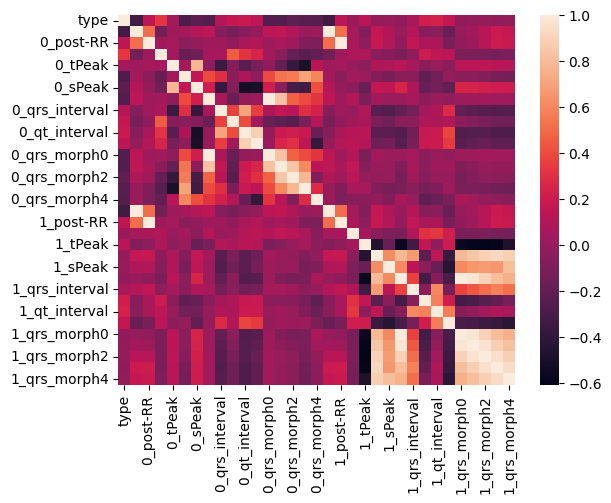

In [13]:
#check for correlations using heatmaps
correlation = sampleOfData.corr()
sns.heatmap(correlation)

Dataset distribution before SMOTE:
type
1    13425
3     1035
2      406
0      132
Name: count, dtype: int64
Dataset distribution after SMOTE:
type
1    13425
3    13425
2    13425
0    13425
Name: count, dtype: int64


C:\Users\black\AppData\Local\Temp\ipykernel_19508\2861652453.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=y_smote.value_counts().index, y=y_smote.value_counts().values, palette='deep')


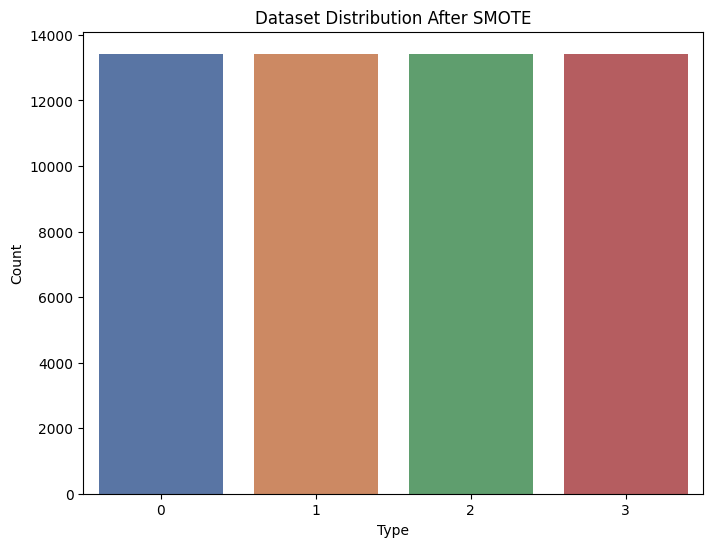

In [14]:
SampleDataset_smote = sampleOfData.copy()

#We are focusing on creating equal numbers for the type of heart beat
X = SampleDataset_smote.drop(columns=['type'])
y = SampleDataset_smote['type']

#Here is smote 
smote = SMOTE(random_state=777) 
X_smote, y_smote = smote.fit_resample(X, y)

#Combine the resampled features back into "dataset_smote"
SampleDataset_smote = pd.concat([X_smote, y_smote], axis=1) 

#Before
print("Dataset distribution before SMOTE:")
print(y.value_counts())

#After
print("Dataset distribution after SMOTE:")
print(y_smote.value_counts())

#Visualization via bar graph
plt.figure(figsize=(8, 6))
sns.barplot(x=y_smote.value_counts().index, y=y_smote.value_counts().values, palette='deep')
plt.title('Dataset Distribution After SMOTE')
plt.xlabel('Type')
plt.ylabel('Count')
plt.show()

#print(SampleDataset_smote.columns)

## Identify the most optimized model

### TODO: Boosting and voting classifier 

In [15]:
# Target --> identifying the type (N (Normal),  SVEB (Supraventricular ectopic beat)
# VEB (Ventricular ectopic beat), F (Fusion beat), and Q (Unknown beat))

# Features --> all other columns 
X = SampleDataset_smote.drop('type', axis=1)
y = SampleDataset_smote['type']


# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=777)

# Standardizing the features
scaler = StandardScaler()
X_trainScaled = scaler.fit_transform(X_train)
X_testScaled = scaler.transform(X_test)

### Logistic Regression (without Normalization)

In [66]:
logisticReg = LogisticRegression(max_iter=1000)
logisticReg.fit(X_trainScaled, y_train) 

yPredLogReg = logisticReg.predict(X_testScaled)

accuracyLR = accuracy_score(y_test, yPredLogReg)
precisionLR = precision_score(y_test, yPredLogReg, average='weighted')
recallLR = recall_score(y_test, yPredLogReg, average='weighted')
f1LR = f1_score(y_test, yPredLogReg, average='weighted')
cmLR = confusion_matrix(y_test, yPredLogReg)

print("Logistic Regression: ")
print(f"Accuracy: {accuracyLR}")
print(f"Precision: {precisionLR}")
print(f"Recall: {recallLR}")
print(f"F1 Score: {f1LR}")
print("Confusion Matrix:")
print(cmLR)
print()


Logistic Regression: 
Accuracy: 0.8935754189944134
Precision: 0.8937460030405937
Recall: 0.8935754189944134
F1 Score: 0.8936048687607606
Confusion Matrix:
[[2518  139   49   77]
 [  95 2305  154   43]
 [  43  103 2384  133]
 [ 127   39  141 2390]]



### Logistic Regression (with Normalization)

In [67]:
normalizer = Normalizer()
X_trainScaledNormal = normalizer.fit_transform(X_trainScaled)
X_testScaledNormal = normalizer.transform(X_testScaled)

logisticRegNorm = LogisticRegression(max_iter=1000)
logisticRegNorm.fit(X_trainScaledNormal, y_train)

yPredLogRegNorm = logisticRegNorm.predict(X_testScaledNormal)

accuracyLRN = accuracy_score(y_test, yPredLogRegNorm)
precisionLRN = precision_score(y_test, yPredLogRegNorm, average='weighted')
recallLRN = recall_score(y_test, yPredLogRegNorm, average='weighted')
f1LRN = f1_score(y_test, yPredLogRegNorm, average='weighted')
cmLRN = confusion_matrix(y_test, yPredLogRegNorm)

print("Logistic Regression Normalized: ")
print(f"Accuracy: {accuracyLRN}")
print(f"Precision: {precisionLRN}")
print(f"Recall: {recallLRN}")
print(f"F1 Score: {f1LRN}")
print("Confusion Matrix:")
print(cmLRN)
print()

Logistic Regression Normalized: 
Accuracy: 0.8722532588454376
Precision: 0.8723322297834012
Recall: 0.8722532588454376
F1 Score: 0.8717862517000117
Confusion Matrix:
[[2529  147   36   71]
 [ 204 2082  237   74]
 [  52  107 2340  164]
 [ 113   48  119 2417]]



### KNN (without Normalization)

In [52]:
knn = KNeighborsClassifier()
knn.fit(X_trainScaled, y_train)

yPredKNN = knn.predict(X_testScaled)

accuracyKNN = accuracy_score(y_test, yPredKNN)
precisionKNN = precision_score(y_test, yPredKNN, average='weighted')
recallKNN = recall_score(y_test, yPredKNN, average='weighted')
f1KNN = f1_score(y_test, yPredKNN, average='weighted')
cmKNN = confusion_matrix(y_test, yPredKNN)

print("KNN: ")
print(f"Accuracy: {accuracyKNN}")
print(f"Precision: {precisionKNN}")
print(f"Recall: {recallKNN}")
print(f"F1 Score: {f1KNN}")
print("Confusion Matrix:")
print(cmKNN)
print()


KNN without normalization
Accuracy: 0.9925512104283054
Precision: 0.9926048818234645
Recall: 0.9925512104283054
F1 Score: 0.9925327826356876
Confusion Matrix:
[[2783    0    0    0]
 [  14 2536   30   17]
 [   0    1 2662    0]
 [  13    2    3 2679]]


### KNN (with Normalization)

In [50]:
normalizer = Normalizer()
X_trainScaledNormal = normalizer.fit_transform(X_trainScaled)
X_testScaledNormal = normalizer.transform(X_testScaled)

knnNorm = KNeighborsClassifier()
knnNorm.fit(X_trainScaledNormal, y_train)

yPredknnNorm = knnNorm.predict(X_testScaledNormal)

accuracyKNNnorm = accuracy_score(y_test, yPredknnNorm)
precisionKNNnorm = precision_score(y_test, yPredknnNorm, average='weighted')
recallKNNnorm = recall_score(y_test, yPredknnNorm, average='weighted')
f1KNNnorm = f1_score(y_test, yPredknnNorm, average='weighted')
cmKNNnorm = confusion_matrix(y_test, yPredknnNorm)

print("KNN Normalized: ")
print(f"Accuracy: {accuracyKNNnorm}")
print(f"Precision: {precisionKNNnorm}")
print(f"Recall: {recallKNNnorm}")
print(f"F1 Score: {f1KNNnorm}")
print("Confusion Matrix:")
print(cmKNNnorm)
print()



KNN with normalization
Accuracy: 0.9932029795158287
Precision: 0.9932467436283523
Recall: 0.9932029795158287
F1 Score: 0.993184979581865
Confusion Matrix:
[[2783    0    0    0]
 [   7 2538   28   24]
 [   0    1 2662    0]
 [  11    1    1 2684]]


### Decision Tree (without Normalization)

In [68]:
decisionTree = DecisionTreeClassifier()
decisionTree.fit(X_trainScaled, y_train)

yPredDT = decisionTree.predict(X_testScaled)

accuracyDT = accuracy_score(y_test, yPredDT)
precisionDT = precision_score(y_test, yPredDT, average='weighted')
recallDT = recall_score(y_test, yPredDT, average='weighted')
f1DT = f1_score(y_test, yPredDT, average='weighted')
cmDT = confusion_matrix(y_test, yPredDT)

print("Decision Tree: ")
print(f"Accuracy: {accuracyDT}")
print(f"Precision: {precisionDT}")
print(f"Recall: {recallDT}")
print(f"F1 Score: {f1DT}")
print("Confusion Matrix:")
print(cmDT)
print()

Decision Tree: 
Accuracy: 0.9829608938547486
Precision: 0.9829437865620422
Recall: 0.9829608938547486
F1 Score: 0.9829391463349468
Confusion Matrix:
[[2770    9    1    3]
 [  26 2515   33   23]
 [   2   27 2616   18]
 [  10   16   15 2656]]



### Decision Tree (with Normalization)

In [69]:
normalizer = Normalizer()
X_trainScaledNormal = normalizer.fit_transform(X_trainScaled)
X_testScaledNormal = normalizer.transform(X_testScaled)

decisionTreeNorm = DecisionTreeClassifier()
decisionTreeNorm.fit(X_trainScaledNormal, y_train)

y_pred_dt_norm = decisionTreeNorm.predict(X_testScaledNormal)

accuracyDTNorm = accuracy_score(y_test, y_pred_dt_norm)
precisionDTNorm = precision_score(y_test, y_pred_dt_norm, average='weighted')
recallDTNorm = recall_score(y_test, y_pred_dt_norm, average='weighted')
f1DTNorm = f1_score(y_test, y_pred_dt_norm, average='weighted')
cmDTNorm = confusion_matrix(y_test, y_pred_dt_norm)

print("Decision Tree: ")
print(f"Accuracy: {accuracyDTNorm}")
print(f"Precision: {precisionDTNorm}")
print(f"Recall: {recallDTNorm}")
print(f"F1 Score: {f1DTNorm}")
print("Confusion Matrix:")
print(cmDTNorm)
print()


Decision Tree: 
Accuracy: 0.9806331471135941
Precision: 0.9806092539411104
Recall: 0.9806331471135941
F1 Score: 0.9806116831731981
Confusion Matrix:
[[2761   17    1    4]
 [  16 2497   43   41]
 [   2   29 2622   10]
 [   8   26   11 2652]]



### SVM without kernel (without Normalization)

In [70]:
linearSVM = svm.LinearSVC(C=0.1, max_iter=5000)
linearSVM.fit(X_trainScaled, y_train)
yPredLSVM = linearSVM.predict(X_testScaled)

accuracyLSVM = accuracy_score(y_test, yPredLSVM)
precisionLSVM = precision_score(y_test, yPredLSVM, average='weighted')
recallLSVM = recall_score(y_test, yPredLSVM, average='weighted')
f1LSVM = f1_score(y_test, yPredLSVM, average='weighted')
cmLSVM = confusion_matrix(y_test, yPredLSVM)

print("Linear SVM: ")
print(f"Accuracy: {accuracyLSVM}")
print(f"Precision: {precisionLSVM}")
print(f"Recall: {recallLSVM}")
print(f"F1 Score: {f1LSVM}")
print("Confusion Matrix:")
print(cmLSVM)
print()

Linear SVM: 
Accuracy: 0.8772811918063315
Precision: 0.8774274745200861
Recall: 0.8772811918063315
F1 Score: 0.877327191710385
Confusion Matrix:
[[2507  139   54   83]
 [ 102 2254  199   42]
 [  35  118 2292  218]
 [ 130   43  155 2369]]



### SVM without Kernel (with Normalization)

In [71]:
normalizer = Normalizer()
X_trainScaledNormal = normalizer.fit_transform(X_trainScaled)
X_testScaledNormal = normalizer.transform(X_testScaled)

linearNSVM = svm.LinearSVC(C=0.1, max_iter=5000)
linearNSVM.fit(X_trainScaledNormal, y_train)
yPredNLSVM = linearNSVM.predict(X_testScaledNormal)

accuracyNLSVM = accuracy_score(y_test, yPredNLSVM)
precisionNLSVM = precision_score(y_test, yPredNLSVM, average='weighted')
recallNLSVM = recall_score(y_test, yPredNLSVM, average='weighted')
f1NLSVM = f1_score(y_test, yPredNLSVM, average='weighted')
cmNLSVM = confusion_matrix(y_test, yPredNLSVM)

print("Linear SVM Normalized: ")
print(f"Accuracy: {accuracyNLSVM}")
print(f"Precision: {precisionNLSVM}")
print(f"Recall: {recallNLSVM}")
print(f"F1 Score: {f1NLSVM}")
print("Confusion Matrix:")
print(cmNLSVM)

Linear SVM Normalized: 
Accuracy: 0.8506517690875233
Precision: 0.8507988725198322
Recall: 0.8506517690875233
F1 Score: 0.8499698566908926
Confusion Matrix:
[[2527  150   30   76]
 [ 217 2014  289   77]
 [  50  114 2231  268]
 [ 138   61  134 2364]]


### Random Forest Classifier (without Normalization)

In [72]:
RFC = RandomForestClassifier()
RFC.fit(X_trainScaled, y_train)
yPredRFC = RFC.predict(X_testScaled)

accuracyRFC = accuracy_score(y_test, yPredRFC)
precisionRFC = precision_score(y_test, yPredRFC, average='weighted')
recallRFC = recall_score(y_test, yPredRFC, average='weighted')
f1RFC = f1_score(y_test, yPredRFC, average='weighted')
cmRFC = confusion_matrix(y_test, yPredRFC)

### Bagging (with Logistic Regression)

In [27]:
bagging_clf = BaggingClassifier(estimator=logisticReg, n_estimators=10, random_state=42)
bagging_clf.fit(X_trainScaled, y_train)
yPredBag = bagging_clf.predict(X_testScaled)

accuracyBag = accuracy_score(y_test, yPredBag)
precisionBag = precision_score(y_test, yPredBag, average='weighted')
recallBag = recall_score(y_test, yPredBag, average='weighted')
f1Bag = f1_score(y_test, yPredBag, average='weighted')
cmBag = confusion_matrix(y_test, yPredBag)

### Boosting (Adaboost)

In [30]:
ada_clf = AdaBoostClassifier(estimator=logisticReg, n_estimators=10, random_state=42)
ada_clf.fit(X_trainScaled, y_train)
yPredAda = ada_clf.predict(X_testScaled)

accuracyAda = accuracy_score(y_test, yPredAda)
precisionAda = precision_score(y_test, yPredAda, average='weighted')
recallAda = recall_score(y_test, yPredAda, average='weighted')
f1Ada = f1_score(y_test, yPredAda, average='weighted')
cmAda = confusion_matrix(y_test, yPredAda)

/opt/anaconda3/envs/env2/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


### Voting Classifier (with weighted average probabilities)

In [29]:
voting_clf = VotingClassifier(
    estimators=[('lr', logisticReg), ('dt', decisionTree), ('knn', knn), ('rfc', RFC)],
    voting='soft' 
)
voting_clf.fit(X_trainScaled, y_train)
yPredVote = voting_clf.predict(X_testScaled)

accuracyVote = accuracy_score(y_test, yPredVote)
precisionVote = precision_score(y_test, yPredVote, average='weighted')
recallVote = recall_score(y_test, yPredVote, average='weighted')
f1Vote = f1_score(y_test, yPredVote, average='weighted')
cmVote = confusion_matrix(y_test, yPredVote)

### Stacking 

In [31]:
#base models
estimators = [
    ('dt', decisionTree),
    ('knn', knn,
    ('rfc', RFC))
]

#meta model
meta_model = logisticReg

stacking_clf = StackingClassifier(estimators=estimators, final_estimator=meta_model)
stacking_clf.fit(X_trainScaled, y_train)
yPredStack = stacking_clf.predict(X_testScaled)

accuracyStack = accuracy_score(y_test, yPredStack)
precisionStack = precision_score(y_test, yPredStack, average='weighted')
recallStack = recall_score(y_test, yPredStack, average='weighted')
f1Stack = f1_score(y_test, yPredStack, average='weighted')
cmStack = confusion_matrix(y_test, yPredStack)

### SVM with Kernel (without Normalization)

In [73]:
svm_rbf = SVC(kernel='rbf', gamma='scale')
svm_rbf.fit(X_trainScaled, y_train)

yPredSVMRBF = svm_rbf.predict(X_testScaled)

accuracySVMRBF = accuracy_score(y_test, yPredSVMRBF)
precisionSVMRBF = precision_score(y_test, yPredSVMRBF, average='weighted')
recallSVMRBF = recall_score(y_test, yPredSVMRBF, average='weighted')
f1SVMRBF = f1_score(y_test, yPredSVMRBF, average='weighted')
cmSVMRBF = confusion_matrix(y_test, yPredSVMRBF)

print("SVM with RBF kernel: ")
print(f"Accuracy: {accuracySVMRBF}")
print(f"Precision: {precisionSVMRBF}")
print(f"Recall: {recallSVMRBF}")
print(f"F1 Score: {f1SVMRBF}")
print("Confusion Matrix:")
print(cmSVMRBF)
print()


SVM with RBF kernel: 
Accuracy: 0.9830540037243948
Precision: 0.9831145012461252
Recall: 0.9830540037243948
F1 Score: 0.9830254569161774
Confusion Matrix:
[[2773   10    0    0]
 [  21 2505   55   16]
 [   0   22 2641    0]
 [  33   19    6 2639]]



### SVM with Kernel (with Normalization)

In [74]:
normalizer = Normalizer()
X_trainScaledNormal = normalizer.fit_transform(X_trainScaled)
X_testScaledNormal = normalizer.transform(X_testScaled)

svm_rbf_norm = SVC(kernel='rbf', gamma='scale')
svm_rbf_norm.fit(X_trainScaledNormal, y_train)

yPredSvmrbfNorm = svm_rbf_norm.predict(X_testScaledNormal)

accuracySVMRBFNorm = accuracy_score(y_test, yPredSvmrbfNorm)
precisionSVMRBFNorm = precision_score(y_test, yPredSvmrbfNorm, average='weighted')
recallSVMRBFNorm = recall_score(y_test, yPredSvmrbfNorm, average='weighted')
f1SVMRBFNorm = f1_score(y_test, yPredSvmrbfNorm, average='weighted')
cmSVMRBFNorm = confusion_matrix(y_test, yPredSvmrbfNorm)

print("SVM with RBF kernel Normalized: ")
print(f"Accuracy: {accuracySVMRBFNorm}")
print(f"Precision: {precisionSVMRBFNorm}")
print(f"Recall: {recallSVMRBFNorm}")
print(f"F1 Score: {f1SVMRBFNorm}")
print("Confusion Matrix:")
print(cmSVMRBFNorm)
print()


SVM with RBF kernel Normalized: 
Accuracy: 0.9884543761638733
Precision: 0.988505054567203
Recall: 0.9884543761638733
F1 Score: 0.9884369647613449
Confusion Matrix:
[[2780    0    0    3]
 [   4 2534   46   13]
 [   0   11 2652    0]
 [  30   13    4 2650]]



### Gaussian Naive Bayes (without Normalization)

In [75]:
gnb = GaussianNB()
gnb.fit(X_trainScaled, y_train)

yPredGNB = gnb.predict(X_testScaled)

accuracyGNB = accuracy_score(y_test, yPredGNB)
precisionGNB = precision_score(y_test, yPredGNB, average='weighted')
recallGNB = recall_score(y_test, yPredGNB, average='weighted')
f1GNB = f1_score(y_test, yPredGNB, average='weighted')
cmGNB = confusion_matrix(y_test, yPredGNB)

print("Gaussian Naive Bayes: ")
print(f"Accuracy: {accuracyGNB}")
print(f"Precision: {precisionGNB}")
print(f"Recall: {recallGNB}")
print(f"F1 Score: {f1GNB}")
print("Confusion Matrix:")
print(cmGNB)
print()

Gaussian Naive Bayes: 
Accuracy: 0.7390130353817504
Precision: 0.7498986309562194
Recall: 0.7390130353817504
F1 Score: 0.7404074929284056
Confusion Matrix:
[[2124  406  204   49]
 [ 190 1486  802  119]
 [   1  222 2238  202]
 [  96  399  113 2089]]



### Gaussian Naive Bayes (with Normalization)

In [76]:
normalizer = Normalizer()
X_trainScaledNormal = normalizer.fit_transform(X_trainScaled)
X_testScaledNormal = normalizer.transform(X_testScaled)

gnb_norm = GaussianNB()
gnb_norm.fit(X_trainScaledNormal, y_train)

yPredgnbNorm = gnb_norm.predict(X_testScaledNormal)

accuracyGNBNorm = accuracy_score(y_test, yPredgnbNorm)
precisionGNBNorm = precision_score(y_test, yPredgnbNorm, average='weighted')
recallGNBNorm = recall_score(y_test, yPredgnbNorm, average='weighted')
f1GNBNorm = f1_score(y_test, yPredgnbNorm, average='weighted')
cmGNBNorm = confusion_matrix(y_test, yPredgnbNorm)

print("Gaussian Naive Bayes Normalized: ")
print(f"Accuracy: {accuracyGNBNorm}")
print(f"Precision: {precisionGNBNorm}")
print(f"Recall: {recallGNBNorm}")
print(f"F1 Score: {f1GNBNorm}")
print("Confusion Matrix:")
print(cmGNBNorm)
print()

Gaussian Naive Bayes Normalized: 
Accuracy: 0.7612662942271881
Precision: 0.7608107709051258
Recall: 0.7612662942271881
F1 Score: 0.7564376462691853
Confusion Matrix:
[[2345  244   95   99]
 [ 244 1384  738  231]
 [  42  145 2190  286]
 [ 146  172  122 2257]]



### Data Summary

In [77]:
print("Logistic Regression: ")
print(f"Accuracy: {accuracyLR}")
print(f"Precision: {precisionLR}")
print(f"Recall: {recallLR}")
print(f"F1 Score: {f1LR}")
print("Confusion Matrix:")
print(cmLR)
print()

print("Logistic Regression Normalized: ")
print(f"Accuracy: {accuracyLRN}")
print(f"Precision: {precisionLRN}")
print(f"Recall: {recallLRN}")
print(f"F1 Score: {f1LRN}")
print("Confusion Matrix:")
print(cmLRN)
print()

print("KNN: ")
print(f"Accuracy: {accuracyKNN}")
print(f"Precision: {precisionKNN}")
print(f"Recall: {recallKNN}")
print(f"F1 Score: {f1KNN}")
print("Confusion Matrix:")
print(cmKNN)
print()

print("KNN Normalized: ")
print(f"Accuracy: {accuracyKNNnorm}")
print(f"Precision: {precisionKNNnorm}")
print(f"Recall: {recallKNNnorm}")
print(f"F1 Score: {f1KNNnorm}")
print("Confusion Matrix:")
print(cmKNNnorm)

print("Decision Tree: ")
print(f"Accuracy: {accuracyDT}")
print(f"Precision: {precisionDT}")
print(f"Recall: {recallDT}")
print(f"F1 Score: {f1DT}")
print("Confusion Matrix:")
print(cmDT)
print()

print("Decision Tree Normalized: ")
print(f"Accuracy: {accuracyDTNorm}")
print(f"Precision: {precisionDTNorm}")
print(f"Recall: {recallDTNorm}")
print(f"F1 Score: {f1DTNorm}")
print("Confusion Matrix:")
print(cmDTNorm)
print()

print(f"Linear SVM: ")
print(f"Accuracy: {accuracyLSVM}")
print(f"Precision: {precisionLSVM}")
print(f"Recall: {recallLSVM}")
print(f"F1 Score: {f1LSVM}")
print("Confusion Matrix:")
print(cmLSVM)
print()

print(f"Linear SVM with Normalization: ")
print(f"Accuracy: {accuracyNLSVM}")
print(f"Precision: {precisionNLSVM}")
print(f"Recall: {recallNLSVM}")
print(f"F1 Score: {f1NLSVM}")
print("Confusion Matrix:")
print(cmNLSVM)
print()

print(f"Random Forest Classifier: ")
print(f"Accuracy: {accuracyRFC}")
print(f"Precision: {precisionRFC}")
print(f"Recall: {recallRFC}")
print(f"F1 Score: {f1RFC}")
print("Confusion Matrix:")
print(cmRFC)
print()

print(f"Bagging with Logistic Regression: ")
print(f"Accuracy: {accuracyBag}")
print(f"Precision: {precisionBag}")
print(f"Recall: {recallBag}")
print(f"F1 Score: {f1Bag}")
print("Confusion Matrix:")
print(cmBag)
print()

print(f"Adaboost with Logistic Regression: ")
print(f"Accuracy: {accuracyAda}")
print(f"Precision: {precisionAda}")
print(f"Recall: {recallAda}")
print(f"F1 Score: {f1Ada}")
print("Confusion Matrix:")
print(cmAda)
print()

print(f"Voting Classifier: ")
print(f"Accuracy: {accuracyVote}")
print(f"Precision: {precisionVote}")
print(f"Recall: {recallVote}")
print(f"F1 Score: {f1Vote}")
print("Confusion Matrix:")
print(cmVote)
print()

print(f"Stacking: ")
print(f"Accuracy: {accuracyStack}")
print(f"Precision: {precisionStack}")
print(f"Recall: {recallStack}")
print(f"F1 Score: {f1Stack}")
print("Confusion Matrix:")
print(cmStack)
print()

print("SVM with RBF Kernel: ")
print(f"Accuracy: {accuracySVMRBF}")
print(f"Precision: {precisionSVMRBF}")
print(f"Recall: {recallSVMRBF}")
print(f"F1 Score: {f1SVMRBF}")
print("Confusion Matrix:")
print(cmSVMRBF)
print()

print("SVM with RBF Kernel Normalized: ")
print(f"Accuracy: {accuracySVMRBFNorm}")
print(f"Precision: {precisionSVMRBFNorm}")
print(f"Recall: {recallSVMRBFNorm}")
print(f"F1 Score: {f1SVMRBFNorm}")
print("Confusion Matrix:")
print(cmSVMRBFNorm)
print()

print("Gaussian Naive Bayes: ")
print(f"Accuracy: {accuracyGNB}")
print(f"Precision: {precisionGNB}")
print(f"Recall: {recallGNB}")
print(f"F1 Score: {f1GNB}")
print("Confusion Matrix:")
print(cmGNB)
print()

print("Gaussian Naive Bayes Normalized: ")
print(f"Accuracy: {accuracyGNBNorm}")
print(f"Precision: {precisionGNBNorm}")
print(f"Recall: {recallGNBNorm}")
print(f"F1 Score: {f1GNBNorm}")
print("Confusion Matrix:")
print(cmGNBNorm)
print()
print()

Logistic Regression: 
Accuracy: 0.8935754189944134
Precision: 0.8937460030405937
Recall: 0.8935754189944134
F1 Score: 0.8936048687607606
Confusion Matrix:
[[2518  139   49   77]
 [  95 2305  154   43]
 [  43  103 2384  133]
 [ 127   39  141 2390]]

Logistic Regression Normalized: 
Accuracy: 0.8722532588454376
Precision: 0.8723322297834012
Recall: 0.8722532588454376
F1 Score: 0.8717862517000117
Confusion Matrix:
[[2529  147   36   71]
 [ 204 2082  237   74]
 [  52  107 2340  164]
 [ 113   48  119 2417]]

KNN: 
Accuracy: 0.9925512104283054
Precision: 0.9926048818234645
Recall: 0.9925512104283054
F1 Score: 0.9925327826356876
Confusion Matrix:
[[2783    0    0    0]
 [  14 2536   30   17]
 [   0    1 2662    0]
 [  13    2    3 2679]]

KNN Normalized: 
Accuracy: 0.9932029795158287
Precision: 0.9932467436283523
Recall: 0.9932029795158287
F1 Score: 0.993184979581865
Confusion Matrix:
[[2783    0    0    0]
 [   7 2538   28   24]
 [   0    1 2662    0]
 [  11    1    1 2684]]
Decision Tree: 


### Data Visual Conclusion

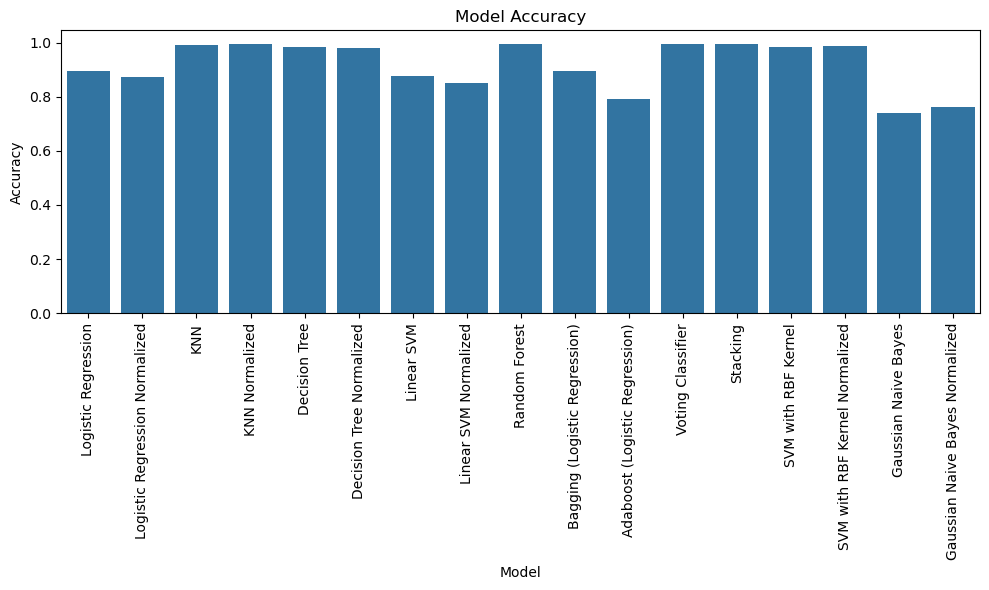

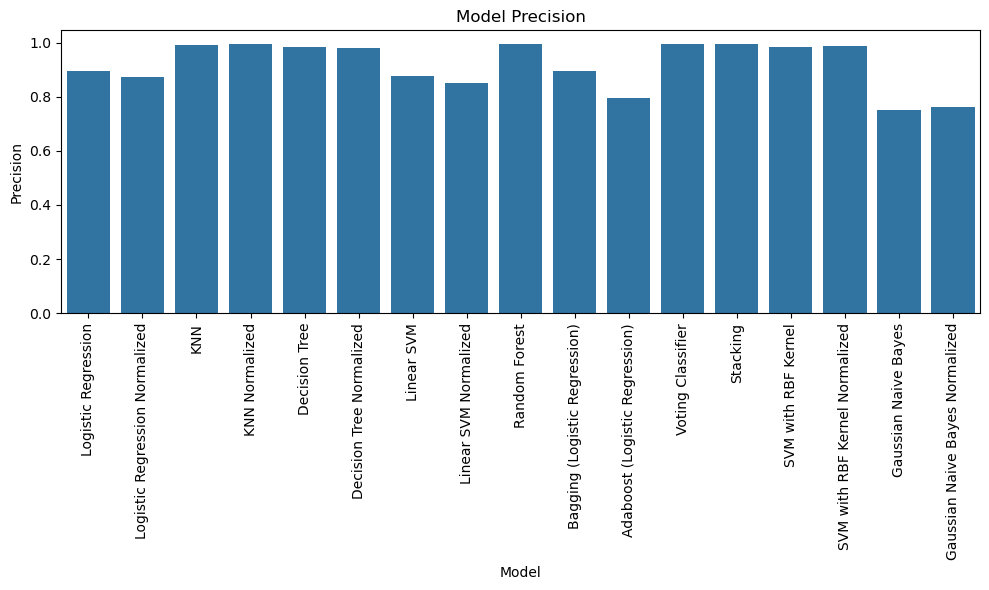

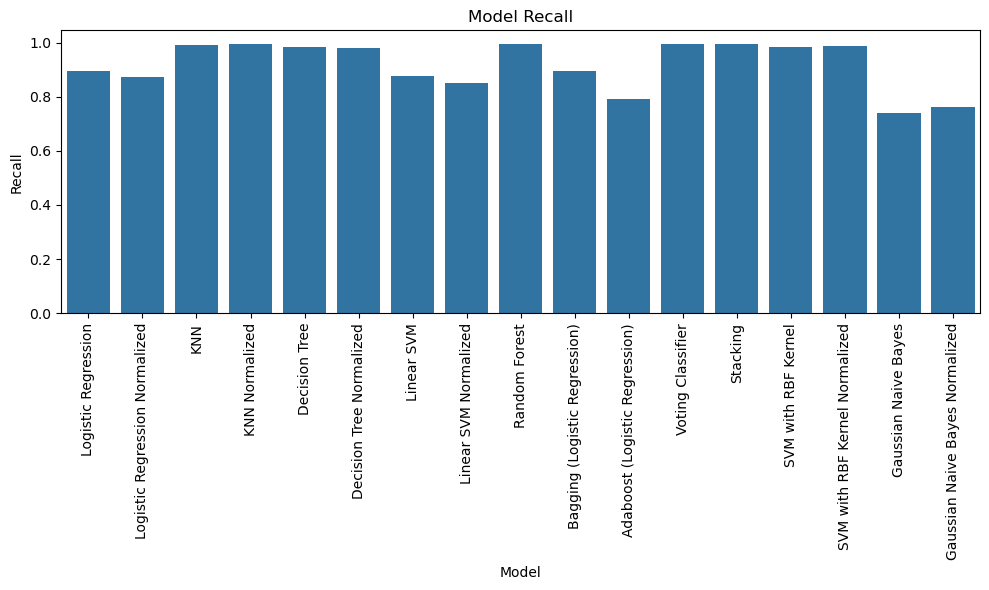

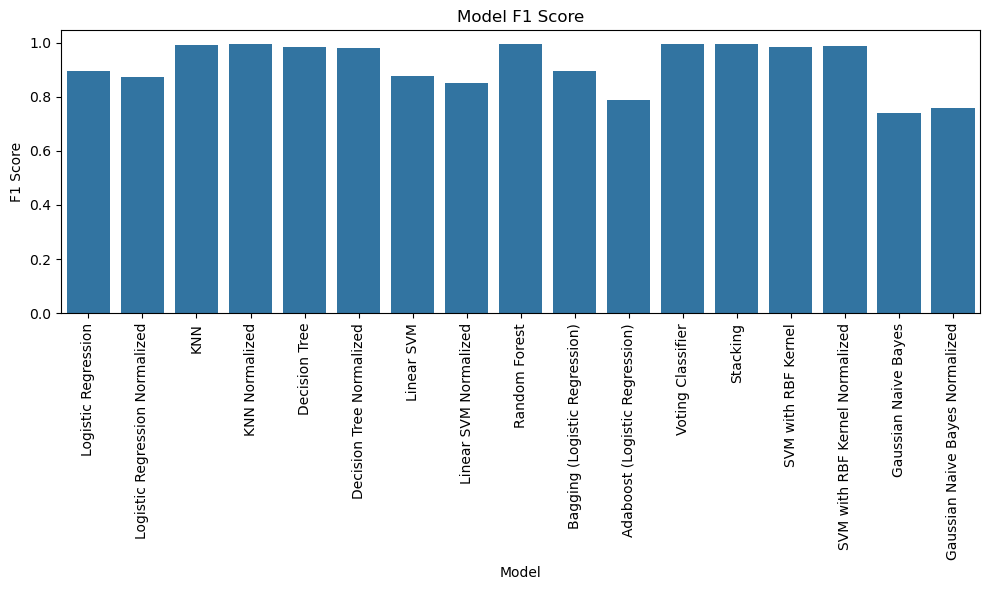

In [78]:
metrics = {
    "Model": ["Logistic Regression", "Logistic Regression Normalized", "KNN", "KNN Normalized",
              "Decision Tree", "Decision Tree Normalized", "Linear SVM", "Linear SVM Normalized",
              "Random Forest", "Bagging (Logistic Regression)", "Adaboost (Logistic Regression)",
              "Voting Classifier", "Stacking", "SVM with RBF Kernel", "SVM with RBF Kernel Normalized",
              "Gaussian Naive Bayes", "Gaussian Naive Bayes Normalized"],
    "Accuracy": [accuracyLR, accuracyLRN, accuracyKNN, accuracyKNNnorm, accuracyDT, accuracyDTNorm,
                 accuracyLSVM, accuracyNLSVM, accuracyRFC, accuracyBag, accuracyAda, accuracyVote,
                 accuracyStack, accuracySVMRBF, accuracySVMRBFNorm, accuracyGNB, accuracyGNBNorm],
    "Precision": [precisionLR, precisionLRN, precisionKNN, precisionKNNnorm, precisionDT, precisionDTNorm,
                  precisionLSVM, precisionNLSVM, precisionRFC, precisionBag, precisionAda, precisionVote,
                  precisionStack, precisionSVMRBF, precisionSVMRBFNorm, precisionGNB, precisionGNBNorm],
    "Recall": [recallLR, recallLRN, recallKNN, recallKNNnorm, recallDT, recallDTNorm,
               recallLSVM, recallNLSVM, recallRFC, recallBag, recallAda, recallVote,
               recallStack, recallSVMRBF, recallSVMRBFNorm, recallGNB, recallGNBNorm],
    "F1 Score": [f1LR, f1LRN, f1KNN, f1KNNnorm, f1DT, f1DTNorm, f1LSVM, f1NLSVM,
                 f1RFC, f1Bag, f1Ada, f1Vote, f1Stack, f1SVMRBF, f1SVMRBFNorm,
                 f1GNB, f1GNBNorm]
}

# Convert to DataFrame
df_metrics = pd.DataFrame(metrics)

# Plot bar chart for Accuracy
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x="Model", y="Accuracy", data=df_metrics, ax=ax)
ax.set_title("Model Accuracy")
ax.tick_params(axis='x', rotation=90)  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

# Plot bar chart for Precision
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x="Model", y="Precision", data=df_metrics, ax=ax)
ax.set_title("Model Precision")
ax.tick_params(axis='x', rotation=90)
plt.tight_layout()
plt.show()

# Plot bar chart for Recall
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x="Model", y="Recall", data=df_metrics, ax=ax)
ax.set_title("Model Recall")
ax.tick_params(axis='x', rotation=90)
plt.tight_layout()
plt.show()

# Plot bar chart for F1 Score
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x="Model", y="F1 Score", data=df_metrics, ax=ax)
ax.set_title("Model F1 Score")
ax.tick_params(axis='x', rotation=90)
plt.tight_layout()
plt.show()


In [79]:
# For me to make to table on excel
precision_df = df_metrics[["Model", "Precision"]]
accuracy_df = df_metrics[["Model", "Accuracy"]]
recall_df = df_metrics[["Model", "Recall"]]
f1_score_df = df_metrics[["Model", "F1 Score"]]

print("Precision Scores:")
print(tabulate(precision_df, headers='keys', tablefmt='tsv', showindex=False))
print("\nAccuracy Scores:")
print(tabulate(accuracy_df, headers='keys', tablefmt='tsv', showindex=False))
print("\nRecall Scores:")
print(tabulate(recall_df, headers='keys', tablefmt='tsv', showindex=False))
print("\nF1 Scores:")
print(tabulate(f1_score_df, headers='keys', tablefmt='tsv', showindex=False))

Precision Scores:
Model                          	  Precision
Logistic Regression            	   0.893746
Logistic Regression Normalized 	   0.872332
KNN                            	   0.992605
KNN Normalized                 	   0.993247
Decision Tree                  	   0.982944
Decision Tree Normalized       	   0.980609
Linear SVM                     	   0.877427
Linear SVM Normalized          	   0.850799
Random Forest                  	   0.994879
Bagging (Logistic Regression)  	   0.894232
Adaboost (Logistic Regression) 	   0.793537
Voting Classifier              	   0.994146
Stacking                       	   0.995254
SVM with RBF Kernel            	   0.983115
SVM with RBF Kernel Normalized 	   0.988505
Gaussian Naive Bayes           	   0.749899
Gaussian Naive Bayes Normalized	   0.760811

Accuracy Scores:
Model                          	  Accuracy
Logistic Regression            	  0.893575
Logistic Regression Normalized 	  0.872253
KNN                            	  0.992551


## Neural Network Implementation

In [20]:
import keras

model = keras.Sequential([
    keras.layers.Dense(256, activation = 'relu', input_shape = (32,)),
    keras.layers.Dense(128, activation = 'relu'),
    keras.layers.Dense(64, activation = 'relu'),
    keras.layers.Dense(4, activation = 'softmax')
])

optimizers = {
    'Momentum': keras.optimizers.SGD(momentum = 0.9),
    'Nesterov': keras.optimizers.SGD(momentum = 0.9, nesterov = True),
    'AdaGrad': keras.optimizers.Adagrad(),
    'RMSProp': keras.optimizers.RMSprop(),
    'Adam': keras.optimizers.Adam(),
    'Nadam': keras.optimizers.Nadam()
}

scores = {
    'Momentum': 0,
    'Nesterov': 0,
    'AdaGrad': 0,
    'RMSProp': 0,
    'Adam': 0,
    'Nadam': 0
}

scores_n = scores

In [21]:
for name, opt in optimizers.items():
    model.compile(optimizer = opt, loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
    model.fit(X_trainScaled, y_train, epochs = 10, validation_split = 0.2)
    loss, accuracy = model.evaluate(X_testScaled, y_test)
    scores[name] = accuracy

normalizer = Normalizer()
X_trainScaledNormal = normalizer.fit_transform(X_trainScaled)
X_testScaledNormal = normalizer.transform(X_testScaled)

for name, opt in optimizers.items():
    model.compile(optimizer = opt, loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
    model.fit(X_trainScaledNormal, y_train, epochs = 10, validation_split = 0.2)
    loss, accuracy = model.evaluate(X_testScaledNormal, y_test)
    scores_n[name] = accuracy

Epoch 1/10
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 1s 760us/step - accuracy: 0.8639 - loss: 0.3877 - val_accuracy: 0.9736 - val_loss: 0.0982
Epoch 2/10
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 1s 684us/step - accuracy: 0.9779 - loss: 0.0762 - val_accuracy: 0.9827 - val_loss: 0.0595
Epoch 3/10
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 1s 692us/step - accuracy: 0.9866 - loss: 0.0441 - val_accuracy: 0.9885 - val_loss: 0.0401
Epoch 4/10
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 1s 691us/step - accuracy: 0.9890 - loss: 0.0349 - val_accuracy: 0.9896 - val_loss: 0.0394
Epoch 5/10
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 1s 683us/step - accuracy: 0.9889 - loss: 0.0364 - val_accuracy: 0.9900 - val_loss: 0.0326
Epoch 6/10
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 1s 683us/step - accuracy: 0.9935 - loss: 0.0223 - val_accuracy: 0.9923 - val_loss: 0.0271
Epoch 7/10
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 1s 718us/step - accuracy: 0.9945 - loss: 0.0172 - val_accuracy: 0.9953 - val_loss: 0.0203
Epoch 8/10
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 1s 695us/step - accuracy: 0.9954 -

In [22]:
for name, score in scores.items():
    print("Accuracy with", name, score)
print()
for name, score in scores_n.items():
    print("(Normalized) Accuracy with", name, score)

Accuracy with Momentum 0.9972997903823853
Accuracy with Nesterov 0.9971135854721069
Accuracy with AdaGrad 0.9972066879272461
Accuracy with RMSProp 0.9966480731964111
Accuracy with Adam 0.9934822916984558
Accuracy with Nadam 0.9959031939506531

(Normalized) Accuracy with Momentum 0.9972997903823853
(Normalized) Accuracy with Nesterov 0.9971135854721069
(Normalized) Accuracy with AdaGrad 0.9972066879272461
(Normalized) Accuracy with RMSProp 0.9966480731964111
(Normalized) Accuracy with Adam 0.9934822916984558
(Normalized) Accuracy with Nadam 0.9959031939506531
